# 04 - Applied ML

In [37]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

## Cleaning the data

In [38]:
# import the data
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

# save initial number of records
initial_records = df.shape[0]

print('Initial shape of the DataFrame:', df.shape)

# initial number of players
initial_players = len(df['playerShort'].unique())

print('Number of players:', initial_players)

Initial shape of the DataFrame: (146028, 28)
Number of players: 2053


We start by checking which columns have NaN values so that we can decide if we should drop some of those columns or some of the records.

In [39]:
# check which columns have NaNs
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID           True
rater1            True
rater2            True
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

We can drop the column photoID since we won't use the photos of the players.

In [40]:
df = df.drop(['photoID'], axis=1)

In order to have a unique skin rating for each player, we compute the geometric mean between the two raters. We do so after removing the records with NaNs in those two columns.

In [41]:
# remove records that have rater1 and/or rater2 as NaNs
df = df.dropna(axis=0, subset=['rater1', 'rater2'])

# create a new column with the geometric mean of the two raters
df['raterMean'] = (df['rater1'] * df['rater2']) ** 0.5

# remove the columns rater1 and rater2
df = df.drop(['rater1', 'rater2'], axis=1)

In [42]:
print('Number of players:', len(df['playerShort'].unique()))

Number of players: 1585


Let's now focus on the referees. As stated in [this notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb), we should only take into account referees that took part in games of one of the considered leagues. This means that referees with less than 22 dyads (corresponding to the, at least, 22 players of a game) shouldn't be relevant.

In [43]:
# compute the number of dyads per referee
refs = df['refNum'].value_counts()

# only keep the referees from the leagues
df = df[df['refNum'].isin(refs[refs > 21].index)]

In [44]:
print('Number of players:', len(df['playerShort'].unique()))

Number of players: 1584


Since we will group the records by player, some of the columns concerning the referees information can be removed, namely: refNum, refCountry and Alpha_3.

In [45]:
df = df.drop(['refNum', 'refCountry', 'Alpha_3'], axis=1)

The columns nIAT, seIAT, nExp and seExp are associated with a particular referee and this information will become irrelevant as soon as the data is aggregated by players. So we'll also remove these features.

In [46]:
df.drop(['nIAT', 'seIAT', 'nExp', 'seExp'], axis=1, inplace=True)

Let's check again the features that have NaNs associated.

In [47]:
# check which columns have NaNs
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
meanIAT           True
meanExp           True
raterMean        False
dtype: bool

In [48]:
df = df.dropna(axis=0, subset=['height', 'weight', 'position'])

print('Number of players:', len(df['playerShort'].unique()))

Number of players: 1418


We can remove the columns that correspond to non-numeric data and that we believe to be irrelevant for the problem:

In [49]:
non_numeric_features = ['player', 'club', 'birthday']
df.drop(non_numeric_features, axis=1, inplace=True)

In [50]:
df.isnull().any()

playerShort      False
leagueCountry    False
height           False
weight           False
position         False
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
meanIAT           True
meanExp           True
raterMean        False
dtype: bool

In [51]:
df = df.dropna(axis=0, subset=['meanIAT', 'meanExp'])

In [52]:
print('Shape of the DataFrame before aggregating by player:', df.shape)
print('Number of features after cleaning the data:', len(df['playerShort'].unique()))

Shape of the DataFrame before aggregating by player: (104420, 16)
Number of features after cleaning the data: 1418


## Aggregating the data (by player)

For each player, we decided to take the means over the meanIAT and the meanExp of the referees with whom the players interacted as an indicator of the mean bias each player faced throughout the games.

In [53]:
grouped_by_player = df.groupby(['playerShort', 'height', 'weight', 'raterMean', 'leagueCountry', 'position'], as_index=False)

clean_data = grouped_by_player.agg({'games': np.sum, 'victories': np.sum, 'ties': np.sum, 'defeats': np.sum, 'goals': np.sum,
                       'yellowCards': np.sum, 'yellowReds': np.sum, 'redCards': np.sum, 'meanIAT': np.mean, 'meanExp': np.mean})

# drop the column playerShort (non-numeric data not relevant for the classifier)
clean_data.drop('playerShort', axis=1, inplace=True)

In [54]:
clean_data = pd.get_dummies(clean_data, prefix = ['dummyCode_','dummyCode_'])

## Training the Classifier

Since we want to train a Random Forest Classifier, we first change the labels to discrete values.

In [55]:
# this would be suitable for multiclass classification
def labels_categories(y):
    if(y['raterMean'] <= 0.2):
        return 0
    elif(y['raterMean'] <= 0.4):
        return 1
    elif(y['raterMean'] <= 0.6):
        return 2
    elif(y['raterMean'] <= 0.8):
        return 3
    else:
        return 4

In [56]:
# reduce the problem to a binary classification problem
def binary_labels(y):
    if(y['raterMean'] < 0.5):
        return 0
    else:
        return 1

In [57]:
clean_data['skin_cat'] = clean_data.apply(binary_labels, axis=1)

X = clean_data.drop(['skin_cat', 'raterMean'], axis=1)
Y = np.asarray(clean_data['skin_cat'], dtype="|S6")

In [58]:
# features that will be used to train the classifier
X.columns

Index(['height', 'weight', 'yellowCards', 'goals', 'meanIAT', 'redCards',
       'games', 'meanExp', 'defeats', 'ties', 'yellowReds', 'victories',
       'dummyCode__England', 'dummyCode__France', 'dummyCode__Germany',
       'dummyCode__Spain', 'dummyCode__Attacking Midfielder',
       'dummyCode__Center Back', 'dummyCode__Center Forward',
       'dummyCode__Center Midfielder', 'dummyCode__Defensive Midfielder',
       'dummyCode__Goalkeeper', 'dummyCode__Left Fullback',
       'dummyCode__Left Midfielder', 'dummyCode__Left Winger',
       'dummyCode__Right Fullback', 'dummyCode__Right Midfielder',
       'dummyCode__Right Winger'],
      dtype='object')

### Selecting the Classifier Parameters

The main two parameters we need to select are the number of trees in the forest and the maximum depth of a tree. To select them and to **to avoid overfitting**, we performed **10-fold crossvalidation**.

In [59]:
from sklearn.cross_validation import KFold

number_splits = 10

kf = KFold(X.shape[0], n_folds=number_splits)

In [60]:
# choose the best value for the number of trees in the forest
train_errors =[]
test_errors = []
number_estimators = range(1, 50)

for nb_est in number_estimators:
    mean_train_error = 0.0
    mean_test_error = 0.0
    
    for train_index, test_index in kf:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        clf = RandomForestClassifier(n_estimators=nb_est, criterion='entropy')
        clf = clf.fit(X_train, Y_train)
        
        train_error = 1.0 - clf.score(X_train, Y_train)
        test_error = 1.0 - clf.score(X_test, Y_test)
        
        mean_train_error += train_error
        mean_test_error += test_error
        
    train_errors.append(mean_train_error/number_splits)
    test_errors.append(mean_test_error/number_splits)

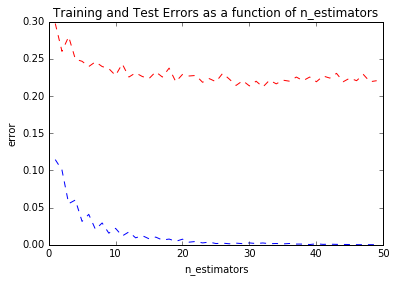

In [61]:
plt.plot(number_estimators, test_errors, 'r--', number_estimators, train_errors, 'b--')
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.title('Training and Test Errors as a function of n_estimators')
plt.show()

In [62]:
# choose the best value for the maximum depth of a tree (setting n_estimators to 10)
train_errors = []
test_errors = []
max_depths = range(1, 20)

for depth in max_depths:
    mean_train_error = 0.0
    mean_test_error = 0.0
    
    for train_index, test_index in kf:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        clf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=depth)
        clf = clf.fit(X_train, Y_train)
        
        train_error = 1.0 - clf.score(X_train, Y_train)
        test_error = 1.0 - clf.score(X_test, Y_test)
        
        mean_train_error += train_error
        mean_test_error += test_error
        
    train_errors.append(mean_train_error/number_splits)
    test_errors.append(mean_test_error/number_splits)

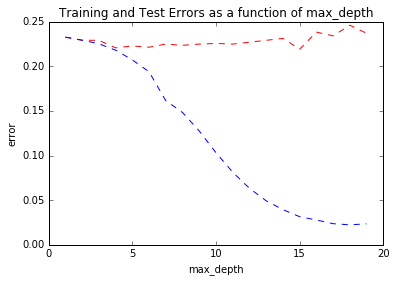

In [63]:
plt.plot(max_depths, test_errors, 'r--', max_depths, train_errors, 'b--')
plt.xlabel('max_depth')
plt.ylabel('error')
plt.title('Training and Test Errors as a function of max_depth')
plt.show()

Analysing both graphs, we decided that we should take **n_estimators=10** and **max_depth=10** to avoid overfitting.

### Analising Feature Importances

mean accuracy: 0.88293370945


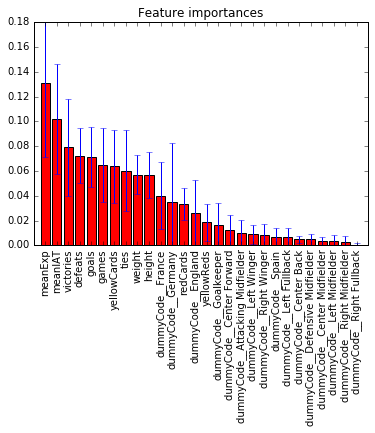

In [64]:
# build a random forest and compute the feature importances
optimal_n_estimators = 10
optimal_max_depth = 10

clf = RandomForestClassifier(n_estimators=optimal_n_estimators, criterion='entropy', max_depth=optimal_max_depth)
clf = clf.fit(X, Y)

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('mean accuracy:', clf.score(X,Y))

# plot the feature importances of the random forest
plot_labels = X.columns[indices]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), plot_labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylim([0,0.18])
plt.show()

mean accuracy: 0.910437235543


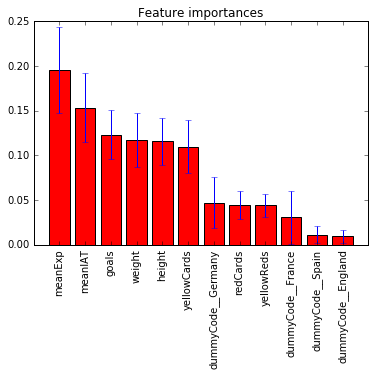

In [65]:
# compute feature importances for a different set of features
X = clean_data.drop(['skin_cat', 'raterMean', 'ties', 'games', 'defeats', 'victories',
                     'dummyCode__Attacking Midfielder', 'dummyCode__Center Back', 'dummyCode__Center Forward',
                     'dummyCode__Center Midfielder', 'dummyCode__Defensive Midfielder',
                     'dummyCode__Goalkeeper', 'dummyCode__Left Fullback',
                     'dummyCode__Left Midfielder', 'dummyCode__Left Winger',
                     'dummyCode__Right Fullback', 'dummyCode__Right Midfielder', 'dummyCode__Right Winger'], axis=1)

Y = np.asarray(clean_data['skin_cat'], dtype="|S6")

clf = RandomForestClassifier(n_estimators=optimal_n_estimators, criterion='entropy', max_depth=optimal_max_depth)
clf = clf.fit(X, Y)

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('mean accuracy:', clf.score(X,Y))

# plot the feature importances of the random forest
plot_labels = X.columns[indices]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), plot_labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

### Bonus: Learning Curves

In [66]:
number_splits = 20

train_errors =[]
test_errors = []
data_sizes = range(number_splits, X.shape[0], 20)

for n in data_sizes:
    kf = KFold(n, n_folds=number_splits)
    
    mean_train_error = 0.0
    mean_test_error = 0.0
    
    for train_index, test_index in kf:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        clf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=10)
        clf = clf.fit(X_train, Y_train)
        
        train_error = 1 - clf.score(X_train, Y_train)
        test_error = 1 - clf.score(X_test, Y_test)
        
        mean_train_error += train_error
        mean_test_error += test_error
        
    train_errors.append(mean_train_error/number_splits)
    test_errors.append(mean_test_error/number_splits)

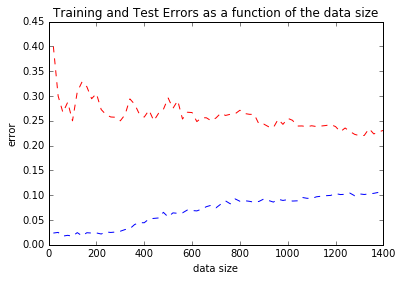

In [67]:
plt.plot(data_sizes, test_errors, 'r--', data_sizes, train_errors, 'b--')
plt.xlabel('data size')
plt.ylabel('error')
plt.title('Training and Test Errors as a function of the data size')
plt.show()

By the shape of the learning curves one can say the model is overfitting (high variance). Performing crossvalidation doesn't seem to be efficient in this case. One reason might be the fact that the sub-samples are picked randomly when we have a Random Forest Classifier.

## Clustering

In [68]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

We now want to apply an unsupervised learning technique and cluster the players in two different clusters. We'll use K-means to do so.
We then focus on the silhouette score and the mean accuracy of the clustering (although it is an unsupervised technique we have the true labels for the dataset) to evaluate how well the model performed.
Not only do we take into account all the features previously used, but we also remove the features iteratively and compute the silhouette score for each new dataset.

In [69]:
X = clean_data.drop(['skin_cat', 'raterMean'], axis=1)
Y = clean_data['skin_cat']

In [70]:
# clusters the data using K-means and computes the silhouette score
def kmeans_score(data):
    kmean = KMeans(n_clusters=2, init='k-means++')
    kmean.fit(data)
    labels = kmean.labels_
    score = silhouette_score(data, labels, metric='euclidean')
    
    return labels, score

In [71]:
# computes the accuracy for each clustering
def compute_accuracy(prediction_labels, labels):
    correct_predictions = (prediction_labels == labels).sum()
    
    accuracy = correct_predictions / len(labels)
    
    return accuracy

In [72]:
labels, score_before = kmeans_score(X)
accuracy_before = compute_accuracy(labels,Y)

print('silhouette without feature removal:', score_before)
print('accuracy without feature removal:', accuracy_before)

silhouette without feature removal: 0.535891062512
accuracy without feature removal: 0.593088857546


We get the silhouette score, the labels associated, and the accuracy of this clustering. Focusing both on the silhouette score and on the accuracy, we conclude the clustering isn't performing well, so let's now remove features iteratively.

At each iteration, we remove each of the features and compute the silhouette score. We then pick the feature to remove as the one which gave a better silhouette score when not considered. In the end, we get the highest silhouette score as well as the set of features that were removed in order to obtain such a score.

In [73]:
def remove_features_iteratively(data):
    best_removed_features = []
    removed_features = []
    
    stop_removing = False
    
    prediction_labels, best_score = kmeans_score(data)
    best_accuracy = compute_accuracy(prediction_labels,Y)
    
    while(not stop_removing):
        new_scores = {}
        accuracies = {}
        
        for feature in data.columns:
            labels, score = kmeans_score(data.drop(best_removed_features + removed_features + [feature], axis=1))
            accuracy = compute_accuracy(labels,Y)
            new_scores[feature] = score
            accuracies[feature] = accuracy
            
        feature_to_remove = max(new_scores, key=lambda k: new_scores[k])
        removed_features.append(feature_to_remove)
        best_new_score = new_scores[feature_to_remove]
            
        if(best_score < best_new_score):
            best_score = best_new_score
            best_accuracy = accuracies[feature_to_remove]
            best_removed_features.extend(removed_features)
            removed_features = []
            
        if(len(data.columns) - len(removed_features) - len(best_removed_features) <= 1):
            stop_removing = True
            
    return best_accuracy, best_score, best_removed_features

In [74]:
accuracy_after, best_score, removed_features = remove_features_iteratively(X)

In [75]:
print('silhouette score after feature removal:', best_score)
print('accuracy with feature removal:', accuracy_after)

silhouette score after feature removal: 0.865229713377
accuracy with feature removal: 0.705923836389


A silhouette score closer to 1 means the clusters are more sparse which should indicate a better clustering. We actually obtained a better result when we don't consider part of the features (both for the silhouette score and the mean accuracy).